# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from lightgbm import LGBMRegressor

from catboost import Pool, CatBoostRegressor, cv

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Прочитаем датасет. В описании указаны столбцы с датами - сразу спарсим их как тип `datetime64`.

In [2]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=[
    'DateCrawled', 
    'DateCreated', 
    'LastSeen'])

Посмотрим информацию о файле.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Посмотрим на количество пропусков в данных.

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Заполним столбец `Notrepaires` пропуска значением `yes`, так как скорее всего владелец заинтересован скрыть факт ремонта своего автомобиля в целях повышения стоимости продажи.

In [6]:
data['NotRepaired'] = data['NotRepaired'].fillna('yes')

Выведем на экран уникальные значения столбцов с пропусками.

In [7]:
display(data['VehicleType'].unique())
display(data['Gearbox'].unique())
display(data['Model'].unique())
display(data['FuelType'].unique())
display(data['NumberOfPictures'].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array([0])

В столбце с количеством фотографий значение 0 во всех строках - значит этот столбец можем отбросить.

Для начала заполним все пропуски словом `unknow`.

In [8]:
data = data.drop(columns='NumberOfPictures', axis=1)
data = data.fillna('unknow')
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64

Необходимо применить технику Ordinal Encoding или порядкового кодирования для столбцов `VehicleType, Gearbox, FuelType, NotRepaired`. Столбец `Model` пока оставим как есть.

In [9]:
encoder = OrdinalEncoder()

data['Model_code'] = pd.DataFrame(encoder.fit_transform(data[['Model']]))
data['Brand_code'] = pd.DataFrame(encoder.fit_transform(data[['Brand']]))
data['VehicleType_code'] = pd.DataFrame(encoder.fit_transform(data[['VehicleType']]))
data['Gearbox_code'] = pd.DataFrame(encoder.fit_transform(data[['Gearbox']]))
data['FuelType_code'] = pd.DataFrame(encoder.fit_transform(data[['FuelType']]))
data['NotRepaired_code'] = pd.DataFrame(encoder.fit_transform(data[['NotRepaired']]))

display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,NotRepaired,DateCreated,PostalCode,LastSeen,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code
0,2016-03-24 11:52:17,480,unknow,1993,manual,0,golf,150000,0,petrol,...,yes,2016-03-24,70435,2016-04-07 03:16:57,116.0,38.0,7.0,1.0,6.0,1.0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,...,yes,2016-03-24,66954,2016-04-07 01:46:50,228.0,1.0,2.0,1.0,2.0,1.0
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,yes,2016-03-14,90480,2016-04-05 12:47:46,117.0,14.0,6.0,0.0,2.0,1.0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,no,2016-03-17,91074,2016-03-17 17:40:17,116.0,38.0,5.0,1.0,6.0,0.0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,no,2016-03-31,60437,2016-04-06 10:17:21,101.0,31.0,5.0,1.0,2.0,0.0


Соберем в таблицу медианное значение (наиболее популярное) типа транспортного средства, закодированного ранее. Это позволит нам в дальнейшем заменить пропуски в таблице на такое значение.

In [10]:
VehicleType = data.query('VehicleType != "unknow"').pivot_table(
    index='Brand', 
    columns='Model', 
    values='VehicleType_code', 
    aggfunc=['median']
)
display(VehicleType.head())

median                                                     ...  \
Model         100  145  147  156  159 1_reihe  1er  200 2_reihe 300c  ...   
Brand                                                                 ...   
alfa_romeo    NaN  5.0  4.0  4.0  8.0     NaN  NaN  NaN     NaN  NaN  ...   
audi          4.0  NaN  NaN  NaN  NaN     NaN  NaN  4.0     NaN  NaN  ...   
bmw           NaN  NaN  NaN  NaN  NaN     NaN  4.0  NaN     NaN  NaN  ...   
chevrolet     NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN     NaN  NaN  ...   
chrysler      NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN     NaN  8.0  ...   

                                                                        \
Model      wrangler x_reihe x_trail x_type xc_reihe yaris yeti ypsilon   
Brand                                                                    
alfa_romeo      NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
audi            NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
bmw             NaN     6.0     NaN    NaN      NaN   NaN  NaN     NaN   
chevrolet       NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
chrysler        NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   

                           
Model      z_reihe zafira  
Brand                      
alfa_romeo     NaN    NaN  
audi           NaN    NaN  
bmw            1.0    NaN  
chevrolet      NaN    NaN  
chrysler       NaN    NaN  

[5 rows x 251 columns]

Также создадим словарь для расшифровки закодированных значений.

In [11]:
dict_VehicleType = data.pivot_table(
    index=['VehicleType_code', 'VehicleType']
).reset_index()
dict_VehicleType = dict_VehicleType[['VehicleType_code', 'VehicleType']].sort_values('VehicleType_code')
dict_VehicleType = dict_VehicleType['VehicleType']
display(dict_VehicleType)

0            bus
1    convertible
2          coupe
3          other
4          sedan
5          small
6            suv
7         unknow
8          wagon
Name: VehicleType, dtype: object

Сделаем тоже для остальных сталбцов с пропусками.

In [12]:
Gearbox = data.query('Gearbox != "unknow"').pivot_table(
    index='Brand', 
    columns='Model', 
    values='Gearbox_code', 
    aggfunc=['median']
)
display(Gearbox.head())

dict_Gearbox = data.pivot_table(
    index=['Gearbox_code', 'Gearbox']
).reset_index()
dict_Gearbox = dict_Gearbox[['Gearbox_code', 'Gearbox']].sort_values('Gearbox_code')
dict_Gearbox = dict_Gearbox['Gearbox']
display(dict_Gearbox)
#################################################
FuelType = data.query('FuelType != "unknow"').pivot_table(
    index='Brand', 
    columns='Model',
    values='FuelType_code', 
    aggfunc=['median']
)
display(FuelType.head())

dict_FuelType = data.pivot_table(
    index=['FuelType_code', 'FuelType']
).reset_index()
dict_FuelType = dict_FuelType[['FuelType_code', 'FuelType']].sort_values('FuelType_code')
dict_FuelType = dict_FuelType['FuelType']
display(dict_FuelType)

median                                                     ...  \
Model         100  145  147  156  159 1_reihe  1er  200 2_reihe 300c  ...   
Brand                                                                 ...   
alfa_romeo    NaN  1.0  1.0  1.0  1.0     NaN  NaN  NaN     NaN  NaN  ...   
audi          1.0  NaN  NaN  NaN  NaN     NaN  NaN  1.0     NaN  NaN  ...   
bmw           NaN  NaN  NaN  NaN  NaN     NaN  1.0  NaN     NaN  NaN  ...   
chevrolet     NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN     NaN  NaN  ...   
chrysler      NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN     NaN  0.0  ...   

                                                                        \
Model      wrangler x_reihe x_trail x_type xc_reihe yaris yeti ypsilon   
Brand                                                                    
alfa_romeo      NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
audi            NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
bmw             NaN     0.0     NaN    NaN      NaN   NaN  NaN     NaN   
chevrolet       NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
chrysler        NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   

                           
Model      z_reihe zafira  
Brand                      
alfa_romeo     NaN    NaN  
audi           NaN    NaN  
bmw            1.0    NaN  
chevrolet      NaN    NaN  
chrysler       NaN    NaN  

[5 rows x 251 columns]

0      auto
1    manual
2    unknow
Name: Gearbox, dtype: object

median                                                     ...  \
Model         100  145  147  156  159 1_reihe  1er  200 2_reihe 300c  ...   
Brand                                                                 ...   
alfa_romeo    NaN  6.0  6.0  6.0  2.0     NaN  NaN  NaN     NaN  NaN  ...   
audi          6.0  NaN  NaN  NaN  NaN     NaN  NaN  6.0     NaN  NaN  ...   
bmw           NaN  NaN  NaN  NaN  NaN     NaN  6.0  NaN     NaN  NaN  ...   
chevrolet     NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN     NaN  NaN  ...   
chrysler      NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN     NaN  2.0  ...   

                                                                        \
Model      wrangler x_reihe x_trail x_type xc_reihe yaris yeti ypsilon   
Brand                                                                    
alfa_romeo      NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
audi            NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
bmw             NaN     2.0     NaN    NaN      NaN   NaN  NaN     NaN   
chevrolet       NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   
chrysler        NaN     NaN     NaN    NaN      NaN   NaN  NaN     NaN   

                           
Model      z_reihe zafira  
Brand                      
alfa_romeo     NaN    NaN  
audi           NaN    NaN  
bmw            6.0    NaN  
chevrolet      NaN    NaN  
chrysler       NaN    NaN  

[5 rows x 251 columns]

0         cng
1    electric
2    gasoline
3      hybrid
4         lpg
5       other
6      petrol
7      unknow
Name: FuelType, dtype: object

Объявим функцию fill_missing_values_VehicleType, которая будет возвращать наиболее популярное значение VehicleType в зависимости от бренда и модели.

In [13]:
def fill_missing_values_VehicleType (row):
    Brand = row['Brand']
    Model = row['Model']
    VehicleType_code = row['VehicleType_code']
    Gearbox_code = row['Gearbox_code']
    FuelType_code = row['FuelType_code']
    NotRepaired_code = row['NotRepaired_code']

# определение пропущенного значения VehicleType
    if VehicleType_code == 7:
        return VehicleType.loc[Brand,('median', Model)]
    else:
        return VehicleType_code

def fill_missing_values_Gearbox (row):
    Brand = row['Brand']
    Model = row['Model']
    VehicleType_code = row['VehicleType_code']
    Gearbox_code = row['Gearbox_code']
    FuelType_code = row['FuelType_code']
    NotRepaired_code = row['NotRepaired_code']

# определение пропущенного значения Gearbox
    if Gearbox_code == 2:
        return Gearbox.loc[Brand,('median', Model)]
    else:
        return Gearbox_code

def fill_missing_values_FuelType (row):
    Brand = row['Brand']
    Model = row['Model']
    VehicleType_code = row['VehicleType_code']
    Gearbox_code = row['Gearbox_code']
    FuelType_code = row['FuelType_code']
    NotRepaired_code = row['NotRepaired_code']

# определение пропущенного значения FuelType
    if FuelType_code == 7:
        return FuelType.loc[Brand,('median', Model)]
    else:
        return FuelType_code

Применим нашу функцию, заполним пропущенные значения.

In [14]:
data['VehicleType_code'] = data.apply(fill_missing_values_VehicleType, axis=1)
data['Gearbox_code'] = data.apply(fill_missing_values_Gearbox, axis=1)
data['FuelType_code'] = data.apply(fill_missing_values_FuelType, axis=1)

display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,NotRepaired,DateCreated,PostalCode,LastSeen,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code
0,2016-03-24 11:52:17,480,unknow,1993,manual,0,golf,150000,0,petrol,...,yes,2016-03-24,70435,2016-04-07 03:16:57,116.0,38.0,4.0,1.0,6.0,1.0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,...,yes,2016-03-24,66954,2016-04-07 01:46:50,228.0,1.0,2.0,1.0,2.0,1.0
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,yes,2016-03-14,90480,2016-04-05 12:47:46,117.0,14.0,6.0,0.0,2.0,1.0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,no,2016-03-17,91074,2016-03-17 17:40:17,116.0,38.0,5.0,1.0,6.0,0.0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,no,2016-03-31,60437,2016-04-06 10:17:21,101.0,31.0,5.0,1.0,2.0,0.0


Проверим, остались ли значения `unknow` в нашей таблице.

In [15]:
display(data['VehicleType_code'].value_counts())
display(data['Gearbox_code'].value_counts())
display(data['FuelType_code'].value_counts())

4.0    108175
5.0     92555
8.0     68188
0.0     31945
1.0     20552
2.0     16742
6.0     12516
3.0      3668
5.5        18
4.5        10
Name: VehicleType_code, dtype: int64

1.0    286051
0.0     68318
Name: Gearbox_code, dtype: int64

6.0    244039
2.0    103547
4.0      5680
0.0       565
3.0       242
5.0       206
1.0        90
Name: FuelType_code, dtype: int64

В столбце `VehicleType_code` имеются странные значения - 4.5 и 5.5. Так как их немного - удалим их.

In [16]:
data = data.drop(index=list(data.query('VehicleType_code == 4.5').index))
data = data.drop(index=list(data.query('VehicleType_code == 5.5').index))

Проверим.

In [17]:
display(data['VehicleType_code'].value_counts())

4.0    108175
5.0     92555
8.0     68188
0.0     31945
1.0     20552
2.0     16742
6.0     12516
3.0      3668
Name: VehicleType_code, dtype: int64

Раскодируем признаки.

In [18]:
def values_VehicleType (row):
    VehicleType_code = row['VehicleType_code']

# определение пропущенного значения VehicleType
    return dict_VehicleType[VehicleType_code]

def values_Gearbox (row):
    Gearbox_code = row['Gearbox_code']

# определение пропущенного значения Gearbox
    return dict_Gearbox[Gearbox_code]

def values_FuelType (row):
    FuelType_code = row['FuelType_code']

# определение пропущенного значения FuelType
    return dict_FuelType[FuelType_code]

In [19]:
data['VehicleType_str'] = data.apply(values_VehicleType, axis=1)
data['Gearbox_str'] = data.apply(values_Gearbox, axis=1)
data['FuelType_str'] = data.apply(values_FuelType, axis=1)

display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code,VehicleType_str,Gearbox_str,FuelType_str
0,2016-03-24 11:52:17,480,unknow,1993,manual,0,golf,150000,0,petrol,...,2016-04-07 03:16:57,116.0,38.0,4.0,1.0,6.0,1.0,sedan,manual,petrol
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,...,2016-04-07 01:46:50,228.0,1.0,2.0,1.0,2.0,1.0,coupe,manual,gasoline
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-04-05 12:47:46,117.0,14.0,6.0,0.0,2.0,1.0,suv,auto,gasoline
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 17:40:17,116.0,38.0,5.0,1.0,6.0,0.0,small,manual,petrol
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-04-06 10:17:21,101.0,31.0,5.0,1.0,2.0,0.0,small,manual,gasoline


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354341 entries, 0 to 354368
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354341 non-null  datetime64[ns]
 1   Price              354341 non-null  int64         
 2   VehicleType        354341 non-null  object        
 3   RegistrationYear   354341 non-null  int64         
 4   Gearbox            354341 non-null  object        
 5   Power              354341 non-null  int64         
 6   Model              354341 non-null  object        
 7   Kilometer          354341 non-null  int64         
 8   RegistrationMonth  354341 non-null  int64         
 9   FuelType           354341 non-null  object        
 10  Brand              354341 non-null  object        
 11  NotRepaired        354341 non-null  object        
 12  DateCreated        354341 non-null  datetime64[ns]
 13  PostalCode         354341 non-null  int64   

С пропусками закончили. Изменим тип данных.

In [21]:
data = data.astype({'VehicleType_code':'int64', 'Gearbox_code':'int64', 'FuelType_code':'int64', 'NotRepaired_code':'int64'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354341 entries, 0 to 354368
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354341 non-null  datetime64[ns]
 1   Price              354341 non-null  int64         
 2   VehicleType        354341 non-null  object        
 3   RegistrationYear   354341 non-null  int64         
 4   Gearbox            354341 non-null  object        
 5   Power              354341 non-null  int64         
 6   Model              354341 non-null  object        
 7   Kilometer          354341 non-null  int64         
 8   RegistrationMonth  354341 non-null  int64         
 9   FuelType           354341 non-null  object        
 10  Brand              354341 non-null  object        
 11  NotRepaired        354341 non-null  object        
 12  DateCreated        354341 non-null  datetime64[ns]
 13  PostalCode         354341 non-null  int64   

Взглянем еще раз на данные.

In [22]:
display(data.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code,VehicleType_str,Gearbox_str,FuelType_str
0,2016-03-24 11:52:17,480,unknow,1993,manual,0,golf,150000,0,petrol,...,2016-04-07 03:16:57,116.0,38.0,4,1,6,1,sedan,manual,petrol
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,...,2016-04-07 01:46:50,228.0,1.0,2,1,2,1,coupe,manual,gasoline
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-04-05 12:47:46,117.0,14.0,6,0,2,1,suv,auto,gasoline
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 17:40:17,116.0,38.0,5,1,6,0,small,manual,petrol
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-04-06 10:17:21,101.0,31.0,5,1,2,0,small,manual,gasoline
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,...,2016-04-06 19:17:07,11.0,2.0,4,1,6,1,sedan,manual,petrol
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,...,2016-04-05 18:18:39,8.0,25.0,1,1,6,0,convertible,manual,petrol
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,...,2016-03-25 16:47:58,166.0,38.0,4,1,6,0,sedan,manual,petrol
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,...,2016-04-04 23:42:13,60.0,10.0,0,1,6,1,bus,manual,petrol
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,unknow,...,2016-03-31 17:17:06,116.0,38.0,5,1,6,1,small,manual,petrol


Посмотрим на выбросы в данных.

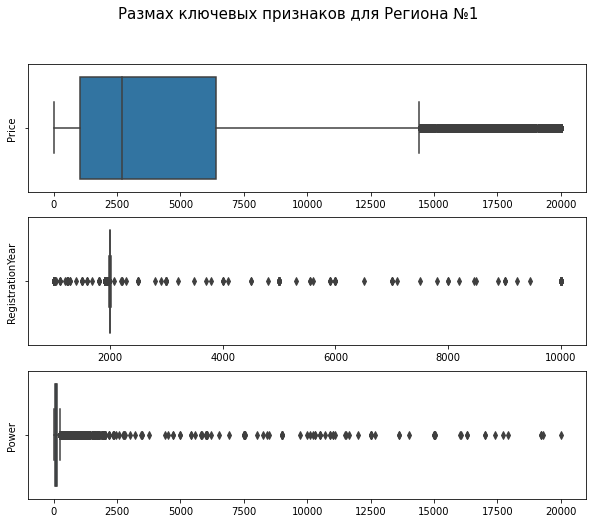

In [23]:
fig, ax = plt.subplots(3,1)

sns.boxplot(x=data['Price'], ax=ax[0])
ax[0].set(xlabel = '', ylabel = 'Price')

sns.boxplot(x=data['RegistrationYear'], ax=ax[1])
ax[1].set(xlabel = '', ylabel = 'RegistrationYear')

sns.boxplot(x=data['Power'], ax=ax[2])
ax[2].set(xlabel = '', ylabel = 'Power')

fig.set_figwidth(10)
fig.set_figheight(8)
fig.suptitle('Размах ключевых признаков для Региона №1', fontsize = 15)

plt.show()

Найдем процент выбросов от общих данных.

In [24]:
data = data.drop(data[data['DateCrawled'].dt.year < data['RegistrationYear']].index, axis=0)
display(data[data['DateCrawled'].dt.year < data['RegistrationYear']])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code,VehicleType_str,Gearbox_str,FuelType_str


Отбросим значения в цене меньше 50.

In [25]:
data = data[data['Price'] > 50]
data = data[data['Power'] > 0]
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,LastSeen,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code,VehicleType_str,Gearbox_str,FuelType_str
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,...,2016-04-07 01:46:50,228.0,1.0,2,1,2,1,coupe,manual,gasoline
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,2016-04-05 12:47:46,117.0,14.0,6,0,2,1,suv,auto,gasoline
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,2016-03-17 17:40:17,116.0,38.0,5,1,6,0,small,manual,petrol
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,2016-04-06 10:17:21,101.0,31.0,5,1,2,0,small,manual,gasoline
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,...,2016-04-06 19:17:07,11.0,2.0,4,1,6,1,sedan,manual,petrol


In [26]:
columns_features = ['Price', 'RegistrationYear', 'Power']
outliers = []
count = 0

for i in columns_features:

    lower_mustache = data[i].quantile(0.25) - 1.5 * (data[i].quantile(0.75) - data[i].quantile(0.25))
    upper_mustache = data[i].quantile(0.75) + 1.5 * (data[i].quantile(0.75) - data[i].quantile(0.25))
    sum_count = len(data.query('@data[@i] < @lower_mustache | @data[@i] > @upper_mustache').index)
    percent = sum_count / len(data[i])

    outliers.append([])
    
    outliers[count].append(i) 
    outliers[count].append(lower_mustache)
    outliers[count].append(upper_mustache)
    outliers[count].append(sum_count)
    outliers[count].append(percent)
    count += 1
       
columns = ['features', 'lower_mustache', 'upper_mustache', 'sum_count', 'percent']

data_outliers = pd.DataFrame(outliers, columns=columns).groupby('features')['percent'].sum()
display(data_outliers)

features
Power               0.021343
Price               0.046216
RegistrationYear    0.015227
Name: percent, dtype: float64

Выбросов не так много, а самих данных достаточно для построения модели, поэтому удалим выбросы.

In [27]:
for j in columns_features:
    lower_mustache = data[j].quantile(0.25) - 1.5 * (data[j].quantile(0.75) - data[j].quantile(0.25))
    upper_mustache = data[j].quantile(0.75) + 1.5 * (data[j].quantile(0.75) - data[j].quantile(0.25))
    drop = data.query('@data[@j] < @lower_mustache | @data[@j] > @upper_mustache')
    data_learn = data.drop(drop.index)
data_learn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289662 entries, 1 to 354368
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        289662 non-null  datetime64[ns]
 1   Price              289662 non-null  int64         
 2   VehicleType        289662 non-null  object        
 3   RegistrationYear   289662 non-null  int64         
 4   Gearbox            289662 non-null  object        
 5   Power              289662 non-null  int64         
 6   Model              289662 non-null  object        
 7   Kilometer          289662 non-null  int64         
 8   RegistrationMonth  289662 non-null  int64         
 9   FuelType           289662 non-null  object        
 10  Brand              289662 non-null  object        
 11  NotRepaired        289662 non-null  object        
 12  DateCreated        289662 non-null  datetime64[ns]
 13  PostalCode         289662 non-null  int64   

В данных есть не информативные столбцы для обучения модели - на цену сильно не влияют дата скачивания анкеты из базы, почтовый индекс, дата последней активности. Также удалим столбцы, которые мы ранее закодировали.

In [28]:
data_learn = data_learn.drop(columns=[
    'DateCrawled', 
    'VehicleType', 
    'Gearbox',
    'FuelType',
    'DateCreated',
    'PostalCode', 
    'LastSeen'], axis=1)
display(data_learn.head())

,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,NotRepaired,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code,VehicleType_str,Gearbox_str,FuelType_str
1,18300,2011,190,unknow,125000,5,audi,yes,228.0,1.0,2,1,2,1,coupe,manual,gasoline
2,9800,2004,163,grand,125000,8,jeep,yes,117.0,14.0,6,0,2,1,suv,auto,gasoline
3,1500,2001,75,golf,150000,6,volkswagen,no,116.0,38.0,5,1,6,0,small,manual,petrol
4,3600,2008,69,fabia,90000,7,skoda,no,101.0,31.0,5,1,2,0,small,manual,gasoline
5,650,1995,102,3er,150000,10,bmw,yes,11.0,2.0,4,1,6,1,sedan,manual,petrol


In [29]:
data_learn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289662 entries, 1 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              289662 non-null  int64  
 1   RegistrationYear   289662 non-null  int64  
 2   Power              289662 non-null  int64  
 3   Model              289662 non-null  object 
 4   Kilometer          289662 non-null  int64  
 5   RegistrationMonth  289662 non-null  int64  
 6   Brand              289662 non-null  object 
 7   NotRepaired        289662 non-null  object 
 8   Model_code         289662 non-null  float64
 9   Brand_code         289662 non-null  float64
 10  VehicleType_code   289662 non-null  int64  
 11  Gearbox_code       289662 non-null  int64  
 12  FuelType_code      289662 non-null  int64  
 13  NotRepaired_code   289662 non-null  int64  
 14  VehicleType_str    289662 non-null  object 
 15  Gearbox_str        289662 non-null  object 
 16  Fu

In [30]:
data_boost = data_learn.drop(columns=[
    'Model_code',
    'Brand_code',
    'NotRepaired_code',
    'FuelType_code',
    'VehicleType_code',
    'Gearbox_code',
    'FuelType_code'], axis=1)
display(data_boost.head())

,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,NotRepaired,VehicleType_str,Gearbox_str,FuelType_str
1,18300,2011,190,unknow,125000,5,audi,yes,coupe,manual,gasoline
2,9800,2004,163,grand,125000,8,jeep,yes,suv,auto,gasoline
3,1500,2001,75,golf,150000,6,volkswagen,no,small,manual,petrol
4,3600,2008,69,fabia,90000,7,skoda,no,small,manual,gasoline
5,650,1995,102,3er,150000,10,bmw,yes,sedan,manual,petrol


In [31]:
data_boost = data_boost.astype({'Model':'category',
           'Brand':'category', 
           'NotRepaired':'category', 
           'VehicleType_str':'category',
           'Gearbox_str':'category', 
           'FuelType_str':'category'})
data_boost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289662 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              289662 non-null  int64   
 1   RegistrationYear   289662 non-null  int64   
 2   Power              289662 non-null  int64   
 3   Model              289662 non-null  category
 4   Kilometer          289662 non-null  int64   
 5   RegistrationMonth  289662 non-null  int64   
 6   Brand              289662 non-null  category
 7   NotRepaired        289662 non-null  category
 8   VehicleType_str    289662 non-null  category
 9   Gearbox_str        289662 non-null  category
 10  FuelType_str       289662 non-null  category
dtypes: category(6), int64(5)
memory usage: 15.2 MB


In [32]:
data_linear = pd.get_dummies(data_boost, drop_first=True)
display(data_linear.head())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,...,VehicleType_str_small,VehicleType_str_suv,VehicleType_str_wagon,Gearbox_str_manual,FuelType_str_electric,FuelType_str_gasoline,FuelType_str_hybrid,FuelType_str_lpg,FuelType_str_other,FuelType_str_petrol
1,18300,2011,190,125000,5,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,1500,2001,75,150000,6,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,3600,2008,69,90000,7,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
5,650,1995,102,150000,10,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [33]:
data_oe = data_learn.drop(columns=[
    'Model',
    'Brand',
    'NotRepaired',
    'VehicleType_str',
    'Gearbox_str',
    'FuelType_str'], axis=1)
display(data_oe.head())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,Model_code,Brand_code,VehicleType_code,Gearbox_code,FuelType_code,NotRepaired_code
1,18300,2011,190,125000,5,228.0,1.0,2,1,2,1
2,9800,2004,163,125000,8,117.0,14.0,6,0,2,1
3,1500,2001,75,150000,6,116.0,38.0,5,1,6,0
4,3600,2008,69,90000,7,101.0,31.0,5,1,2,0
5,650,1995,102,150000,10,11.0,2.0,4,1,6,1


Выделим признаки для обучения и целевой признак. Приступим к обучению моделей.

In [34]:
features_boost = data_boost.drop(columns=['Price'], axis=1)
target_boost = data_learn['Price']

features_train_boost, features_valid_boost, target_train_boost, target_valid_boost = train_test_split(
    features_boost, target_boost, test_size=0.20, random_state=12345)

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
    features_train_boost, target_train_boost, test_size=0.25, random_state=12345)

In [35]:
features_linear = data_linear.drop(columns=['Price'], axis=1)
target_linear = data_learn['Price']

features_train_linear, features_valid_linear, target_train_linear, target_valid_linear = train_test_split(
    features_linear, target_linear, test_size=0.20, random_state=12345)

features_train_linear, features_test_linear, target_train_linear, target_test_linear = train_test_split(
    features_train_linear, target_train_linear, test_size=0.25, random_state=12345)

In [36]:
features_oe = data_oe.drop(columns=['Price'], axis=1)
target_oe = data_learn['Price']

features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(
    features_oe, target_oe, test_size=0.20, random_state=12345)

features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
    features_train_oe, target_train_oe, test_size=0.25, random_state=12345)

**Вывод**

Подведем итоги первого раздела:
1. Проведен обзор данных;
2. Обработали пропуска наиболее популярными значениями для конкретной марки и модели;
3. Убрали выбросы из данных;
4. Подготовили данные для обучения.

## Обучение моделей

Линейная регрессия.

In [37]:
%%time

model_linear_reg = LinearRegression()

cross_valid_linear_reg = (cross_val_score(model_linear_reg, 
                             features_train_linear, 
                             target_train_linear, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
display(f'RMSE LinearRegression = {cross_valid_linear_reg}')

'RMSE LinearRegression = 2649.9811373742605'

CPU times: user 1min 39s, sys: 1min 22s, total: 3min 1s
Wall time: 3min 2s


Решающее дерево.

In [38]:
%%time

model_tree = DecisionTreeRegressor() 
max_depth = [i for i in range(2, 20)]
params = [{'criterion':['mse'], 
                'max_depth':max_depth, 
                'random_state':[12345]}]

grid_tree = GridSearchCV(model_tree, params, scoring='neg_mean_squared_error')
grid_tree.fit(features_train_oe, target_train_oe)
display("Лучшие параметры для модели:")
display(grid_tree.best_params_)
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
cross_valid_tree = (max(means)*-1) ** 0.5
display(f'RMSE DecisionTreeRegressor cross valid = {cross_valid_tree}')

'Лучшие параметры для модели:'

{'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}

'RMSE DecisionTreeRegressor cross valid = 1879.4838201959158'

CPU times: user 46.8 s, sys: 0 ns, total: 46.8 s
Wall time: 47.7 s


In [39]:
%%time

model_tree = DecisionTreeRegressor(
    criterion='mse', 
    max_depth=12, 
    random_state=12345).fit(features_train_oe, target_train_oe)
pred_tree = model_tree.predict(features_valid_oe)
rmse_tree = (mean_squared_error(target_valid_oe, pred_tree))**0.5
display(f'RMSE DecisionTreeRegressor = {rmse_tree:.2f}')

'RMSE DecisionTreeRegressor = 1837.83'

CPU times: user 611 ms, sys: 0 ns, total: 611 ms
Wall time: 628 ms


CatBoost.

In [40]:
%%time

cat_boost_reg = CatBoostRegressor(learning_rate=0.5,
                random_state=12345,
                verbose=False).fit(features_train_boost, target_train_boost, cat_features=[
    'Model', 'Brand', 'NotRepaired', 'VehicleType_str', 'Gearbox_str', 'FuelType_str'])

pred_cat = cat_boost_reg.predict(features_valid_boost)

rmse_cat = (mean_squared_error(target_valid_boost, pred_cat))**0.5
display(f'RMSE CatBoost = {rmse_cat:.2f}')

'RMSE CatBoost = 1535.29'

CPU times: user 5min 31s, sys: 0 ns, total: 5min 31s
Wall time: 5min 40s


LightGBM

In [41]:
%%time

lgbm_reg = LGBMRegressor(num_leaves=200, 
                learning_rate= 0.3,
                random_state=12345).fit(
    features_train_boost, 
    target_train_boost,
)

pred_lgbm = lgbm_reg.predict(features_valid_boost)

rmse_lgbm = (mean_squared_error(target_valid_boost, pred_lgbm))**0.5
display(f'RMSE LightGBM = {rmse_lgbm:.2f}')

'RMSE LightGBM = 1510.79'

CPU times: user 38min 55s, sys: 18.4 s, total: 39min 14s
Wall time: 39min 29s


## Анализ моделей

Проанализируем время работы моделей и их качество на тестовой выборке.

Первым на очереди модель на основе линейной регрессии. Измерим время обучения, предсказания и точность модели.

In [42]:
%%time

model_linear_reg = LinearRegression().fit(features_train_linear, target_train_linear)

CPU times: user 22.6 s, sys: 20.9 s, total: 43.4 s
Wall time: 43.8 s


In [43]:
%%time

pred_linear = model_linear_reg.predict(features_test_linear)

CPU times: user 193 ms, sys: 134 ms, total: 328 ms
Wall time: 372 ms


In [44]:
rmse_linear = (mean_squared_error(target_test_linear, pred_linear))**0.5
display(f'RMSE LinearRegression = {rmse_linear:.2f}')

'RMSE LinearRegression = 2637.12'

Вторым проверим модель дерева решений.

In [45]:
%%time

model_tree = DecisionTreeRegressor(
    criterion='mse', 
    max_depth=12, 
    random_state=12345).fit(features_train_oe, target_train_oe)

CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 564 ms


In [46]:
%%time

pred_tree = model_tree.predict(features_test_oe)

CPU times: user 17.5 ms, sys: 0 ns, total: 17.5 ms
Wall time: 27.5 ms


In [47]:
rmse_tree = (mean_squared_error(target_test_oe, pred_tree))**0.5
display(f'RMSE DecisionTreeRegressor = {rmse_tree:.2f}')

'RMSE DecisionTreeRegressor = 1850.20'

Посмотрим на работу CatBoost.

In [48]:
%%time

cat_boost_reg = CatBoostRegressor(learning_rate=0.5,
                random_state=12345,
                verbose=False).fit(features_train_boost, target_train_boost, cat_features=[
    'Model', 'Brand', 'NotRepaired', 'VehicleType_str', 'Gearbox_str', 'FuelType_str'])

CPU times: user 5min 20s, sys: 0 ns, total: 5min 20s
Wall time: 5min 27s


In [49]:
%%time

pred_cat = cat_boost_reg.predict(features_test_boost)

CPU times: user 807 ms, sys: 0 ns, total: 807 ms
Wall time: 815 ms


In [50]:
rmse_cat = (mean_squared_error(target_test_boost, pred_cat))**0.5
display(f'RMSE DecisionTreeRegressor = {rmse_cat:.2f}')

'RMSE DecisionTreeRegressor = 1522.87'

Теперь изучим LightGBM.

In [51]:
%%time

lgbm_reg = LGBMRegressor(num_leaves=200, 
                learning_rate= 0.3,
                random_state=12345).fit(features_train_boost, target_train_boost)

CPU times: user 21min 47s, sys: 2.89 s, total: 21min 50s
Wall time: 21min 59s


In [52]:
%%time

pred_lgbm = lgbm_reg.predict(features_test_boost)

CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.21 s


In [53]:
rmse_lgbm = (mean_squared_error(target_test_boost, pred_lgbm))**0.5
display(f'RMSE DecisionTreeRegressor = {rmse_lgbm:.2f}')

'RMSE DecisionTreeRegressor = 1503.86'

**Вывод**

Сложилась очень интересная картина: самый точный алгоритм - LightGBM, но по времени он проигрывает абсолютно всем, причем с большим отрывом - учится 22 минуты, предсказывает 1,2 секунды. CatBoost ведет себя лучше: обучается 5,5 минут, предсказывает 815 мс, ошибка 1522, что больше LightGBM на 20, что совсем не значительно. Дерево решений обучается быстрее - 564 мс, предсказывает тоже быстрее - 27 мс, но точность уже 1850. Линейная регрессия сильно проигрывает в точности. Подведу итог, к продакшену следует рассмотреть CatBoost или же дерево решений.